In [1]:
import pandas as pd

# Load the dataset
file_path = "data_science_extract(in) (3).csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Keep only relevant columns
columns_to_keep = [
    'careerjunction_za_skills',
    'careerjunction_za_historical_jobtitles',
    'careerjunction_za_future_jobtitles'
]
df_cleaned = df[columns_to_keep].copy()

# Drop rows with missing skills or job history
df_cleaned.dropna(subset=['careerjunction_za_skills', 'careerjunction_za_historical_jobtitles'], inplace=True)

# Combine skills and historical job titles into one text column
df_cleaned['combined_text'] = (
    df_cleaned['careerjunction_za_skills'].astype(str) + ' ' +
    df_cleaned['careerjunction_za_historical_jobtitles'].astype(str)
)

# Clean formatting like [u'...'] and commas
df_cleaned['combined_text'] = df_cleaned['combined_text'].str.replace(r"[\[\]u'\",]", '', regex=True)

# Show a sample
df_cleaned[['combined_text', 'careerjunction_za_future_jobtitles']].head()


,combined_text,careerjunction_za_future_jobtitles
0,Microbiology microsoft powerpoint microsoft of...,Engineering & Technical Roles
1,C# Developer MYSQL PHP javascript CSS3 HTML5 w...,Software Development
2,Java delphi Excel excel Bloomberg,Data Analysis & Business Intelligence
3,commnication skills Microsoft office MVC JavaS...,Software Development
4,PHP SQL Javascript Linx Python PostgreSQL AWS ...,Software Development


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert combined text to numeric format using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = vectorizer.fit_transform(df_cleaned['combined_text'])

# Show shape of the TF-IDF matrix
X_tfidf.shape


(1430, 1000)

In [5]:
from sklearn.cluster import KMeans

# Apply KMeans with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_tfidf)

# Add cluster labels to the dataframe
df_cleaned['kmeans_cluster'] = clusters_kmeans

# Show sample with KMeans cluster
df_cleaned[['combined_text', 'careerjunction_za_future_jobtitles', 'kmeans_cluster']].head()


,combined_text,careerjunction_za_future_jobtitles,kmeans_cluster
0,Microbiology microsoft powerpoint microsoft of...,Engineering & Technical Roles,2
1,C# Developer MYSQL PHP javascript CSS3 HTML5 w...,Software Development,6
2,Java delphi Excel excel Bloomberg,Data Analysis & Business Intelligence,7
3,commnication skills Microsoft office MVC JavaS...,Software Development,6
4,PHP SQL Javascript Linx Python PostgreSQL AWS ...,Software Development,6


In [7]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering with the same number of clusters (10)
agglo = AgglomerativeClustering(n_clusters=10)
clusters_agglo = agglo.fit_predict(X_tfidf.toarray())

# Add the results to the dataframe
df_cleaned['agglo_cluster'] = clusters_agglo

# Show a sample
df_cleaned[['combined_text', 'careerjunction_za_future_jobtitles', 'agglo_cluster']].head()


,combined_text,careerjunction_za_future_jobtitles,agglo_cluster
0,Microbiology microsoft powerpoint microsoft of...,Engineering & Technical Roles,0
1,C# Developer MYSQL PHP javascript CSS3 HTML5 w...,Software Development,1
2,Java delphi Excel excel Bloomberg,Data Analysis & Business Intelligence,0
3,commnication skills Microsoft office MVC JavaS...,Software Development,1
4,PHP SQL Javascript Linx Python PostgreSQL AWS ...,Software Development,4


In [9]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores
sil_kmeans = silhouette_score(X_tfidf, df_cleaned['kmeans_cluster'])
sil_agglo = silhouette_score(X_tfidf, df_cleaned['agglo_cluster'])

print("KMeans Silhouette Score:", sil_kmeans)
print("Agglomerative Silhouette Score:", sil_agglo)


KMeans Silhouette Score: 0.023179121622298716
Agglomerative Silhouette Score: 0.012098483661515256


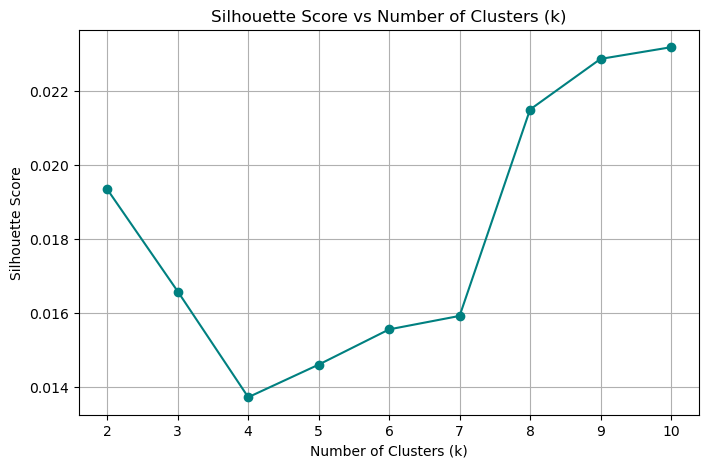

In [19]:
# We tested k values from 2 to 10.
# Based on the silhouette score plot, k = 10 gave the highest score,
# indicating better-defined and well-separated clusters.
# That's why we used k = 10 in both KMeans and Agglomerative for fair comparison.

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try multiple values of k and store silhouette scores
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels)
    silhouette_scores.append(score)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='teal')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [21]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())


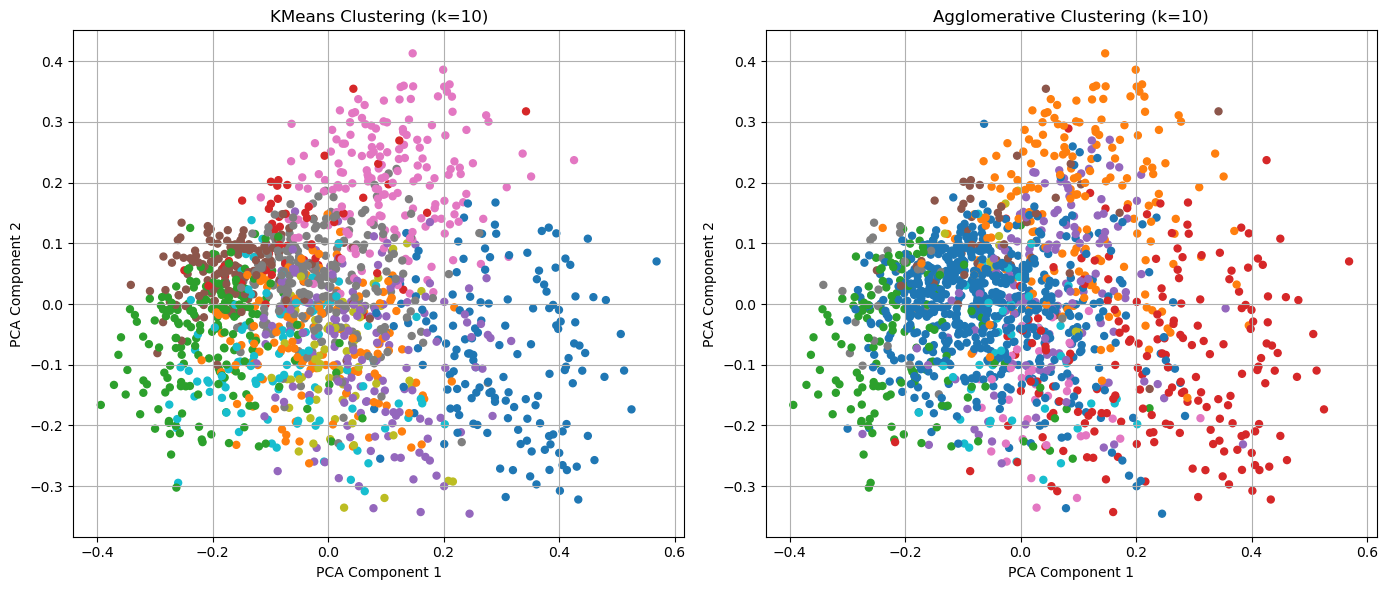

In [23]:
import matplotlib.pyplot as plt

# Plotting side-by-side
plt.figure(figsize=(14, 6))

# KMeans Clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cleaned['kmeans_cluster'], cmap='tab10', s=25)
plt.title("KMeans Clustering (k=10)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)

# Agglomerative Clusters
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cleaned['agglo_cluster'], cmap='tab10', s=25)
plt.title("Agglomerative Clustering (k=10)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)

plt.tight_layout()
plt.show()


In [27]:
### Visual Comparison

### The PCA visualization shows the differences between KMeans and Agglomerative Clustering.

###- **KMeans** produces more compact and slightly more separated clusters.
###- **Agglomerative** clustering results in more overlapping clusters, with less defined boundaries.

###These observations align with the Silhouette Score results, where **KMeans scored higher**, indicating better cluster quality.


In [29]:
# Show the most common future job titles per KMeans cluster
df_cleaned.groupby('kmeans_cluster')['careerjunction_za_future_jobtitles'].value_counts().groupby('kmeans_cluster').head(3)


kmeans_cluster  careerjunction_za_future_jobtitles   
0               Software Development                     123
                Data Analysis & Business Intelligence      8
                IT Support & Administration                7
1               Software Development                      80
                IT Support & Administration               11
                Data Analysis & Business Intelligence     10
2               Project Management                        50
                Software Development                      32
                IT Support & Administration               28
3               Software Development                      19
                IT Support & Administration               12
                Consulting & Business Analysis             6
4               Software Development                      73
                Data Analysis & Business Intelligence     23
                IT Support & Administration               17
5               Software Develo